### Data and Preprocessing

In [255]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('carvana.csv')
df.head()

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
0,1,1/7/2009 0:12,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,...,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389,0
1,2,1/7/2009 0:12,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,...,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630,0
2,3,1/7/2009 0:12,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,...,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020,0
3,4,1/7/2009 0:12,ADESA,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,...,9451.0,NaN,NaN,19638,33619,FL,5600.0,0,594,0
4,5,1/21/2009 0:12,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,12560.0,NaN,NaN,19638,33619,FL,8800.0,0,920,0


In [256]:
df.shape

(6798, 34)

In [257]:
df.dtypes

RefId                                  int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrent

In [258]:
df['BYRNO'] = df['BYRNO'].astype('object')
df['VNZIP1'] = df['VNZIP1'].astype('object')

In [259]:
df = df.set_index('RefId')
df.head()

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
1,1/7/2009 0:12,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,...,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389,0
2,1/7/2009 0:12,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,...,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630,0
3,1/7/2009 0:12,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,...,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020,0
4,1/7/2009 0:12,ADESA,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,...,9451.0,NaN,NaN,19638,33619,FL,5600.0,0,594,0
5,1/21/2009 0:12,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,...,12560.0,NaN,NaN,19638,33619,FL,8800.0,0,920,0


In [260]:
df['PRIMEUNIT'].value_counts()

NO     324
YES     15
Name: PRIMEUNIT, dtype: int64

In [261]:
df['AUCGUART'].value_counts()

GREEN    326
RED       13
Name: AUCGUART, dtype: int64

Kako promenljive AUCGUART i PRIMEUNIT imaju ogroman broj NA vrednosti, te kolone izbacujemo iz dalje analize

In [262]:
df.drop(['AUCGUART', 'PRIMEUNIT'], axis = 1, inplace = True)
df.head()

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
1,1/7/2009 0:12,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,...,5557.0,7146.0,8702.0,19638,33619,FL,4900.0,0,1389,0
2,1/7/2009 0:12,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,...,2646.0,4375.0,5518.0,19638,33619,FL,4100.0,0,630,0
3,1/7/2009 0:12,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,...,4384.0,6739.0,7911.0,19638,33619,FL,4000.0,0,1020,0
4,1/7/2009 0:12,ADESA,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,...,5827.0,8149.0,9451.0,19638,33619,FL,5600.0,0,594,0
5,1/21/2009 0:12,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,...,8934.0,11135.0,12560.0,19638,33619,FL,8800.0,0,920,0


- Kolone AUCGUART i PRIMEUNIT imaju mnogo NA vrednosti, pa su izbacene
- Kolona WheelTypeID je suvisna (postoji kolona WheelType), pa je izbacena

In [263]:
df['BYRNO'].value_counts()

99761    367
18880    323
22916    265
3453     260
21973    254
        ... 
18091      2
1041       1
16369      1
1141       1
1055       1
Name: BYRNO, Length: 61, dtype: int64

#### Popunjavanje nedostajucih vrednosti

In [264]:
df.isna().sum()

PurchDate                               0
Auction                              3815
VehYear                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                  232
SubModel                                0
Color                                   0
Transmission                            0
WheelTypeID                           283
WheelType                             339
VehOdo                                  0
Nationality                             1
Size                                    1
TopThreeAmericanName                    1
MMRAcquisitionAuctionAveragePrice       1
MMRAcquisitionAuctionCleanPrice         1
MMRAcquisitionRetailAveragePrice        1
MMRAcquisitonRetailCleanPrice           1
MMRCurrentAuctionAveragePrice          21
MMRCurrentAuctionCleanPrice            21
MMRCurrentRetailAveragePrice           21
MMRCurrentRetailCleanPrice        

In [265]:
df['Trim'].value_counts()

Bas    1316
LS      921
SE      859
SXT     338
LT      318
       ... 
RT        1
Max       1
Ove       1
ZTW       1
ZX2       1
Name: Trim, Length: 104, dtype: int64

Nedostajuce vrednosti kao i kategorije sa manje od 20 ponavljanja kod promenljive Trim smo zamenili kategorijom Other

In [266]:
df['Trim'].fillna('Other', inplace = True)

In [267]:
low_freq_trim = df['Trim'].value_counts()[df['Trim'].value_counts() < 20]
df['Trim'] = ['Other' if x in low_freq_trim else x for x in df['Trim']]
df['Trim'].value_counts()

Bas      1316
LS        921
SE        859
Other     543
SXT       338
LT        318
LX        225
Tou       212
EX        200
GLS       138
XLT       123
SEL       119
SLT       112
Spo       106
Lim       105
Lar        92
XLS        78
ST         76
2          74
ES         72
GT         68
S          61
i          59
SES        59
LE         58
SLE        55
XL         47
Nor        47
ZX4        47
Cla        45
GL         37
GS         31
150        26
Cus        24
STX        24
Adv        22
s          21
3          20
CX         20
Name: Trim, dtype: int64

In [268]:
df['WheelType'].value_counts()

Alloy     3376
Covers    3083
Name: WheelType, dtype: int64

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

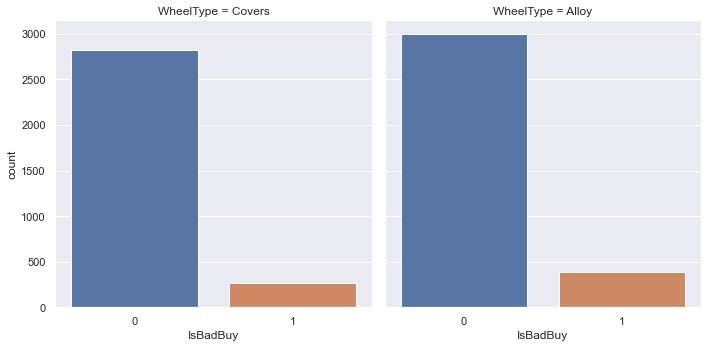

In [270]:
sns.catplot(x = 'IsBadBuy', col = 'WheelType', data = df[df['WheelType'].notna()], kind = 'count')

In [271]:
pd.crosstab(df['WheelType'], df['IsBadBuy'], normalize = 'index')

IsBadBuy,0,1
WheelType,,
Alloy,0.886552,0.113448
Covers,0.913720,0.086280


Primenom hi kvadrat testa (R) vidimo da postoji statisticki znacajaj uticaj promenljive WheelType na izlaznu promenlivu
pa cemo NA vrednosti popuniti tako sto cemo tamo gde je IsBadBuy == 1 upisati vrednost 'Alloy' za prom. WheelType,
a tamo gde je IsBadBuy == 0, upisati vrednost 'Covers' za prom. WheelType

In [272]:
df.loc[(df['IsBadBuy'] == 1) & (df['WheelType'].isna()), 'WheelType'] = 'Alloy'
df.loc[(df['IsBadBuy'] == 0) & (df['WheelType'].isna()), 'WheelType'] = 'Covers'

In [273]:
pd.crosstab(df['WheelType'], df['IsBadBuy'], normalize = 'index')

IsBadBuy,0,1
WheelType,,
Alloy,0.833009,0.166991
Covers,0.917005,0.082995


In [274]:
df.loc[df['Nationality'].isna(), :]

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
6496,1/24/2010 0:02,ADESA,2008,2,JEEP,PATRIOT 2WD 4C,Spo,4D SUV SPORT,BLACK,AUTO,...,11695.0,14026.0,15410.0,21053,85226,NaN,9955.0,0,825,0


In [275]:
df.loc[df['Size'].isna(), :]

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
6496,1/24/2010 0:02,ADESA,2008,2,JEEP,PATRIOT 2WD 4C,Spo,4D SUV SPORT,BLACK,AUTO,...,11695.0,14026.0,15410.0,21053,85226,NaN,9955.0,0,825,0


In [276]:
df.loc[df['TopThreeAmericanName'].isna(), :]

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
6496,1/24/2010 0:02,ADESA,2008,2,JEEP,PATRIOT 2WD 4C,Spo,4D SUV SPORT,BLACK,AUTO,...,11695.0,14026.0,15410.0,21053,85226,NaN,9955.0,0,825,0


Kako za isti automobil nedostaju vrednosti promenljivih Nationality, Size i TopThreeAmericanName, uklonicemo taj red

In [277]:
df = df.loc[~df['Nationality'].isna(), :]
df.isna().sum()

PurchDate                               0
Auction                              3815
VehYear                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelTypeID                           283
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       1
MMRAcquisitionAuctionCleanPrice         1
MMRAcquisitionRetailAveragePrice        1
MMRAcquisitonRetailCleanPrice           1
MMRCurrentAuctionAveragePrice          21
MMRCurrentAuctionCleanPrice            21
MMRCurrentRetailAveragePrice           21
MMRCurrentRetailCleanPrice        

In [278]:
df.loc[df['MMRAcquisitionAuctionAveragePrice'].isna(), :]

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
530,1/13/2010 0:07,NaN,2004,6,NISSAN,TITAN PICKUP 2WD V8,LE,EXT CAB 5.6L,WHITE,AUTO,...,NaN,NaN,NaN,835,85040,NaN,10440.0,0,1272,0


Kako za isti automobil nedostaju vrednosti promenljivih MMRAcquisitionAuctionAveragePrice, MMRAcquisitionAuctionCleanPrice, MMRAcquisitionRetailAveragePrice i MMRAcquisitonRetailCleanPrice, uklonicemo taj red

In [279]:
df = df.loc[~df['MMRAcquisitionAuctionAveragePrice'].isna(), :]
df.isna().sum()

PurchDate                               0
Auction                              3814
VehYear                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelTypeID                           283
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice         0
MMRAcquisitionRetailAveragePrice        0
MMRAcquisitonRetailCleanPrice           0
MMRCurrentAuctionAveragePrice          20
MMRCurrentAuctionCleanPrice            20
MMRCurrentRetailAveragePrice           20
MMRCurrentRetailCleanPrice        

In [280]:
df.loc[df['MMRCurrentAuctionAveragePrice'].isna(), :]

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
116,1/31/2009 0:03,ADESA,2005,4,CHEVROLET,MALIBU 4C 2.2L I4 MP,Bas,4D SEDAN,WHITE,AUTO,...,NaN,NaN,NaN,8655,38118,NaN,5870.0,0,1113,0
159,1/16/2009 0:03,ADESA,2003,6,FORD,TAURUS 3.0L V6 EFI,SES,4D SEDAN SES,GOLD,AUTO,...,NaN,NaN,NaN,19638,33619,FL,4100.0,0,1353,0
550,1/18/2009 0:06,NaN,2008,1,CHRYSLER,SEBRING 4C 2.4L I4 E,LX,4D SEDAN,BLUE,AUTO,...,NaN,NaN,NaN,18881,30272,NaN,8245.0,0,834,0
1772,1/24/2009 0:03,OTHER,2006,3,CHEVROLET,COBALT 2.2L I4 MPI,LS,4D SEDAN LS,GREEN,AUTO,...,NaN,NaN,NaN,21053,95673,NaN,5705.0,0,623,0
2619,1/26/2009 0:08,NaN,2008,1,CHRYSLER,SEBRING 4C 2.4L I4 E,Bas,2D CONVERTIBLE,BLUE,AUTO,...,NaN,NaN,NaN,3453,80011,NaN,9315.0,0,920,0
2624,1/17/2010 0:03,NaN,2008,2,JEEP,PATRIOT 2WD 4C,Spo,4D SUV,SILVER,AUTO,...,NaN,NaN,NaN,22916,80011,NaN,8905.0,0,754,0
2645,1/5/2009 0:08,OTHER,2008,1,CHRYSLER,SEBRING 4C 2.4L I4 E,LX,4D SEDAN,RED,AUTO,...,NaN,NaN,NaN,99761,74135,NaN,7500.0,0,920,0
3523,1/12/2009 0:02,NaN,2005,4,FORD,TAURUS 3.0L V6 EFI,SE,4D SEDAN SE,SILVER,AUTO,...,NaN,NaN,NaN,17212,76040,NaN,5255.0,0,983,0
3528,1/12/2009 0:03,NaN,2005,4,FORD,TAURUS 3.0L V6 EFI,SE,4D SEDAN SE FFV,SILVER,AUTO,...,NaN,NaN,NaN,19064,76040,NaN,4940.0,0,983,0


Kako za istih 20 automobila nedostaju vrednosti promenljivih: MMRCurrentAuctionAveragePrice, MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice i MMRCurrentRetailCleanPrice - uklonicemo tih 20 redova

In [281]:
df = df.loc[~df['MMRCurrentAuctionAveragePrice'].isna(), :]
df.isna().sum()

PurchDate                               0
Auction                              3805
VehYear                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelTypeID                           283
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice         0
MMRAcquisitionRetailAveragePrice        0
MMRAcquisitonRetailCleanPrice           0
MMRCurrentAuctionAveragePrice           0
MMRCurrentAuctionCleanPrice             0
MMRCurrentRetailAveragePrice            0
MMRCurrentRetailCleanPrice        

- Kako kolone Auction i VNST imaju ogroman broj NA vrednosti, te kolone cemo izbaciti iz dalje analize
- Takodje, kolona VNST je suvisna jer imamo kolonu VNZIP1 na osnovu koje mozemo za odredimo VNST

In [282]:
df.drop(['Auction', 'VNST'], axis = 1, inplace = True)
df.isna().sum()

PurchDate                              0
VehYear                                0
VehicleAge                             0
Make                                   0
Model                                  0
Trim                                   0
SubModel                               0
Color                                  0
Transmission                           0
WheelTypeID                          283
WheelType                              0
VehOdo                                 0
Nationality                            0
Size                                   0
TopThreeAmericanName                   0
MMRAcquisitionAuctionAveragePrice      0
MMRAcquisitionAuctionCleanPrice        0
MMRAcquisitionRetailAveragePrice       0
MMRAcquisitonRetailCleanPrice          0
MMRCurrentAuctionAveragePrice          0
MMRCurrentAuctionCleanPrice            0
MMRCurrentRetailAveragePrice           0
MMRCurrentRetailCleanPrice             0
BYRNO                                  0
VNZIP1          

Kolona WheelTypeID je suvisna jer imamo kolonu WheelType, pa cemo nju izbaciti

In [283]:
df.drop('WheelTypeID', axis = 1, inplace = True)
df.isna().sum()

PurchDate                            0
VehYear                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
BYRNO                                0
VNZIP1                               0
VehBCost                             0
IsOnlineSale             

### Raspodela izlazne promenljive

In [284]:
df['IsBadBuy'].value_counts(normalize=True)

0    0.872344
1    0.127656
Name: IsBadBuy, dtype: float64

In [285]:
df.dtypes

PurchDate                             object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrentAuctionCleanPrice          float64
MMRCurrentRetailAveragePrice         float64
MMRCurrentRetailCleanPrice           float64
BYRNO     

In [286]:
df['VNZIP1'] = df['VNZIP1'].astype('object')
df['IsOnlineSale'] = df['IsOnlineSale'].map({0: 'No', 1: 'Yes'})
df['IsBadBuy'] = df['IsBadBuy'].map({0: 'No', 1: 'Yes'})
df.dtypes

PurchDate                             object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrentAuctionCleanPrice          float64
MMRCurrentRetailAveragePrice         float64
MMRCurrentRetailCleanPrice           float64
BYRNO     

In [287]:
df = df.drop(['PurchDate', 'BYRNO'], axis = 1)
df.head()

,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelType,VehOdo,...,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,,,,
1,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,Covers,73807,...,8457.0,4035.0,5557.0,7146.0,8702.0,33619,4900.0,No,1389,No
2,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,Alloy,65617,...,5690.0,1844.0,2646.0,4375.0,5518.0,33619,4100.0,No,630,No
3,2005,4,FORD,FOCUS,Other,2D COUPE ZX3,SILVER,MANUAL,Covers,69367,...,8707.0,3247.0,4384.0,6739.0,7911.0,33619,4000.0,No,1020,No
4,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,Covers,81054,...,8577.0,4709.0,5827.0,8149.0,9451.0,33619,5600.0,No,594,No
5,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,Alloy,76173,...,12443.0,7159.0,8934.0,11135.0,12560.0,33619,8800.0,No,920,No


## Sredjivanje pogresno unetih podataka

In [288]:
len(df.loc[(df['MMRAcquisitionAuctionAveragePrice'] == 0) | (df['MMRAcquisitionAuctionAveragePrice'] == 1), 'MMRAcquisitionAuctionAveragePrice'])

69

#### Vidimo da postoje redovi u kojima je cena 0 ili 1 dolar, sto ukazuje na gresku u podacima pa cemo te redove zameniti aritmetickom sredinom

In [289]:

df.loc[(df['MMRAcquisitionAuctionAveragePrice'] == 0) | (df['MMRAcquisitionAuctionAveragePrice'] == 1), 'MMRAcquisitionAuctionAveragePrice'] = df.loc[(df['MMRAcquisitionAuctionAveragePrice'] != 0) & (df['MMRAcquisitionAuctionAveragePrice'] != 1), 'MMRAcquisitionAuctionAveragePrice'].mean()
df.loc[(df['MMRAcquisitionAuctionCleanPrice'] == 0) | (df['MMRAcquisitionAuctionCleanPrice'] == 1), 'MMRAcquisitionAuctionCleanPrice'] = df.loc[(df['MMRAcquisitionAuctionCleanPrice'] != 0) & (df['MMRAcquisitionAuctionCleanPrice'] != 1), 'MMRAcquisitionAuctionCleanPrice'].mean()
df.loc[(df['MMRAcquisitionRetailAveragePrice'] == 0) | (df['MMRAcquisitionRetailAveragePrice'] == 1), 'MMRAcquisitionRetailAveragePrice'] = df.loc[(df['MMRAcquisitionRetailAveragePrice'] != 0) & (df['MMRAcquisitionRetailAveragePrice'] != 1), 'MMRAcquisitionRetailAveragePrice'].mean()
df.loc[(df['MMRAcquisitonRetailCleanPrice'] == 0) | (df['MMRAcquisitonRetailCleanPrice'] == 1), 'MMRAcquisitonRetailCleanPrice'] = df.loc[(df['MMRAcquisitonRetailCleanPrice'] != 0) & (df['MMRAcquisitonRetailCleanPrice'] != 1), 'MMRAcquisitonRetailCleanPrice'].mean()
df.loc[(df['MMRCurrentAuctionAveragePrice'] == 0) | (df['MMRCurrentAuctionAveragePrice'] == 1), 'MMRCurrentAuctionAveragePrice'] = df.loc[(df['MMRCurrentAuctionAveragePrice'] != 0) & (df['MMRCurrentAuctionAveragePrice'] != 1), 'MMRCurrentAuctionAveragePrice'].mean()
df.loc[(df['MMRCurrentAuctionCleanPrice'] == 0) | (df['MMRCurrentAuctionCleanPrice'] == 1), 'MMRCurrentAuctionCleanPrice'] = df.loc[(df['MMRCurrentAuctionCleanPrice'] != 0) & (df['MMRCurrentAuctionCleanPrice'] != 1), 'MMRCurrentAuctionCleanPrice'].mean()
df.loc[(df['MMRCurrentRetailAveragePrice'] == 0) | (df['MMRCurrentRetailAveragePrice'] == 1), 'MMRCurrentRetailAveragePrice'] = df.loc[(df['MMRCurrentRetailAveragePrice'] != 0) & (df['MMRCurrentRetailAveragePrice'] != 1), 'MMRCurrentRetailAveragePrice'].mean()
df.loc[(df['MMRCurrentRetailCleanPrice'] == 0) | (df['MMRCurrentRetailCleanPrice'] == 1), 'MMRCurrentRetailCleanPrice'] = df.loc[(df['MMRCurrentRetailCleanPrice'] != 0) & (df['MMRCurrentRetailCleanPrice'] != 1), 'MMRCurrentRetailCleanPrice'].mean()

### Eksportovanje ociscenih podatak u CSV fajl

In [290]:
df.to_csv('~/Desktop/Masinsko/projekat/cleaned.csv')

# Podela podataka na trening i test skup

In [291]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split

RAND_STATE = 23

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RAND_STATE, stratify=y)

In [292]:
X_train.shape

(5420, 1364)

In [293]:
X_test.shape

(1356, 1364)

# Kreiranje prediktivnih modela sa podrazumevanim parametrima i bez selekcije atributa

In [294]:
cv_dict_lr = cross_validate(LogisticRegression(solver='liblinear', random_state=RAND_STATE), X_train, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_lr["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_lr["test_roc_auc"].mean()}')

Accuracy: 0.8723247232472324
AUC: 0.6347052757157554


In [295]:
cv_dict_dt = cross_validate(DecisionTreeClassifier(random_state=RAND_STATE), X_train, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_dt["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_dt["test_roc_auc"].mean()}')

Accuracy: 0.8011070110701105
AUC: 0.5380983260283101


In [296]:
cv_dict_nb = cross_validate(GaussianNB(), X_train, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_nb["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_nb["test_roc_auc"].mean()}')

Accuracy: 0.7391143911439114
AUC: 0.6452886469040434


In [297]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_standardized = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_standardized = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [298]:
X_train_standardized.head()

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,...,VNZIP1_92504,VNZIP1_92807,VNZIP1_94544,VNZIP1_95673,VNZIP1_97060,VNZIP1_97217,VNZIP1_97402,VNZIP1_98064,IsOnlineSale_No,IsOnlineSale_Yes
0,-0.771011,0.475142,-1.901077,-1.448453,-1.464467,-1.695122,-1.721106,-1.131847,-1.329688,-1.518900,...,-0.069427,-0.118456,-0.090468,-0.161035,-0.019213,-0.047106,-0.013584,-0.047106,0.166382,-0.166382
1,0.960569,-1.271199,0.193701,0.607090,0.543594,0.052227,0.039540,0.612968,0.547464,-0.024125,...,-0.069427,-0.118456,-0.090468,-0.161035,-0.019213,-0.047106,-0.013584,-0.047106,0.166382,-0.166382
2,-2.502590,2.803598,0.444932,-1.852739,-1.909302,-1.434279,-1.593375,-1.956531,-2.079102,-1.614855,...,-0.069427,-0.118456,-0.090468,-0.161035,-0.019213,-0.047106,-0.013584,-0.047106,0.166382,-0.166382
3,-0.193818,-0.106971,-0.711856,0.442427,0.274019,-0.087972,-0.196701,0.314490,0.178656,-0.280116,...,-0.069427,-0.118456,-0.090468,-0.161035,-0.019213,-0.047106,-0.013584,-0.047106,0.166382,-0.166382
4,-0.193818,-0.106971,-0.272477,-0.882452,-0.847424,-1.213872,-1.180108,-1.115521,-1.143571,-0.690167,...,-0.069427,-0.118456,-0.090468,-0.161035,-0.019213,-0.047106,-0.013584,-0.047106,0.166382,-0.166382


In [299]:
cv_dict_knn = cross_validate(KNeighborsClassifier(n_neighbors=5), X_train_standardized, y_train, cv = 10, scoring = ['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_knn["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_knn["test_roc_auc"].mean()}')

Accuracy: 0.8597785977859779
AUC: 0.5356669565881383


# Selekcija atributa

## Ispitivanje korelacija

<AxesSubplot:>

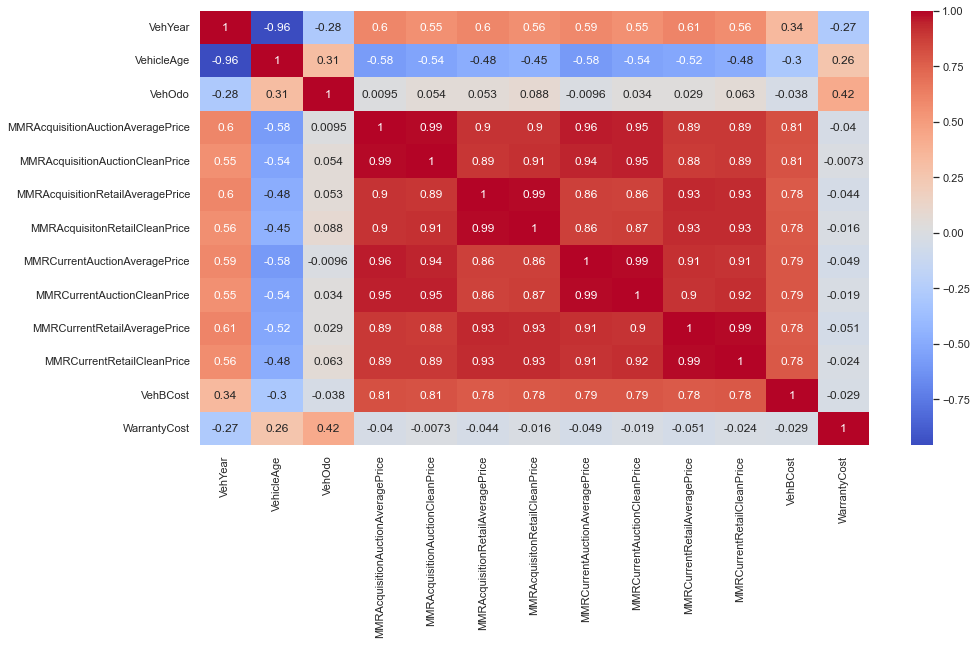

In [300]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')

Kako je promenljiva VehYear gotovo savrseno korelisana sa promenljivom VegAge, izbacicemo promenljivu VehYear iz dalje analize

In [301]:
df.drop('VehYear', axis = 1, inplace = True)

In [302]:
df.columns

Index(['VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color',
       'Transmission', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VNZIP1', 'VehBCost', 'IsOnlineSale',
       'WarrantyCost', 'IsBadBuy'],
      dtype='object')

Kako su sve "MMR" promenljive visoko korelisane sa prvom "MMR", ostavicemo samo tu prvu u daljoj analizi

In [303]:
df = df.iloc[:, list(range(0, 13)) + list(range(20, 25))]
df.head()

,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
RefId,,,,,,,,,,,,,,,,,,
1,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,33619,4900.0,No,1389,No
2,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,33619,4100.0,No,630,No
3,4,FORD,FOCUS,Other,2D COUPE ZX3,SILVER,MANUAL,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,33619,4000.0,No,1020,No
4,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,Covers,81054,OTHER ASIAN,MEDIUM,OTHER,3901.0,33619,5600.0,No,594,No
5,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,Alloy,76173,AMERICAN,LARGE TRUCK,CHRYSLER,6407.0,33619,8800.0,No,920,No


In [304]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RAND_STATE, stratify=y)

# Kreiranje prediktivnih modela sa izbacenim visoko korelisanim atributima

In [305]:
cv_dict_lr = cross_validate(LogisticRegression(solver='liblinear', random_state=RAND_STATE), X_train, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_lr["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_lr["test_roc_auc"].mean()}')

Accuracy: 0.8723247232472324
AUC: 0.6089332492326444


In [306]:
cv_dict_dt = cross_validate(DecisionTreeClassifier(random_state=RAND_STATE), X_train, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_dt["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_dt["test_roc_auc"].mean()}')

Accuracy: 0.7985239852398525
AUC: 0.5243431175871709


In [307]:
cv_dict_nb = cross_validate(GaussianNB(), X_train, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_nb["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_nb["test_roc_auc"].mean()}')

Accuracy: 0.8464944649446494
AUC: 0.6673206831571085


# Izbor 20 najvaznijih atributa

In [308]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k = 20, score_func = chi2)
selection.fit(X_train, y_train)
X_train_reduced = X_train.loc[:, selection.get_support()]
X_train_reduced.columns

Index(['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'VehBCost',
       'WarrantyCost', 'Model_CENTURY V6 3.1L V6 S', 'Model_ESCAPE 2WD V6',
       'Model_MAXIMA MFI V6 3.5L D', 'Model_WINDSTAR FWD V6 3.8L',
       'SubModel_4D CUV 2.0L XLS', 'SubModel_4D CUV 3.0L XLS',
       'SubModel_4D SUV 3.7L SLT', 'SubModel_4D SUV 4.7L',
       'SubModel_PASSENGER 3.8L LX', 'WheelType_Alloy', 'WheelType_Covers',
       'Size_LARGE', 'Size_MEDIUM SUV', 'VNZIP1_19440', 'VNZIP1_91752'],
      dtype='object')

In [309]:
X_test_reduced = X_test.loc[:, selection.get_support()]

In [310]:
X_train_reduced.shape

(5420, 20)

In [311]:
X_test_reduced.shape

(1356, 20)

# Kreiranje prediktivnih modela sa izabranim atributima

In [312]:
cv_dict_lr = cross_validate(LogisticRegression(solver='liblinear', random_state=RAND_STATE), X_train_reduced, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_lr["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_lr["test_roc_auc"].mean()}')

Accuracy: 0.8723247232472324
AUC: 0.6089454678883524


In [313]:
cv_dict_dt = cross_validate(DecisionTreeClassifier(random_state=RAND_STATE), X_train_reduced, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_dt["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_dt["test_roc_auc"].mean()}')

Accuracy: 0.7854243542435424
AUC: 0.5347089470528444


In [315]:
cv_dict_nb = cross_validate(GaussianNB(), X_train_reduced, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_nb["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_nb["test_roc_auc"].mean()}')

Accuracy: 0.8549815498154982
AUC: 0.6706780099659613


In [360]:
logistic_params = {'C':np.linspace(start=0, stop=3, num=50)}
grid = GridSearchCV(LogisticRegression(solver='liblinear', random_state = RAND_STATE), logistic_params, cv=10, scoring='roc_auc')
grid.fit(X_train_reduced, y_train)

print('Best param: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best param:  {'C': 0.18367346938775508}
Best score:  0.6089699799452204


In [ ]:
logistic_params = {'C':np.linspace(start=0, stop=3, num=50)}
grid = GridSearchCV(LogisticRegression(solver='liblinear', random_state = RAND_STATE), logistic_params, cv=10, scoring='roc_auc')
grid.fit(X_train_reduced, y_train)

print('Best param: ', grid.best_params_)
print('Best score: ', grid.best_score_)

# Balansiranje klasa izlazne promenljive

## Undersampling

In [316]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy = 1, random_state = RAND_STATE)
X_rus, y_rus = rus.fit_resample(X_train_reduced, y_train)
y_rus.value_counts()

No     692
Yes    692
Name: IsBadBuy, dtype: int64

In [321]:
cv_dict_lr = cross_validate(LogisticRegression(solver = 'liblinear', random_state=RAND_STATE), X_rus, y_rus, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_lr["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_dt["test_roc_auc"].mean()}')

Accuracy: 0.6076634344698154
AUC: 0.6582191616407117


In [317]:
cv_dict_dt = cross_validate(DecisionTreeClassifier(random_state=RAND_STATE), X_rus, y_rus, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_dt["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_dt["test_roc_auc"].mean()}')

Accuracy: 0.5579032426232927
AUC: 0.557888198757764


In [322]:
cv_dict_nb = cross_validate(GaussianNB(), X_rus, y_rus, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_nb["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_nb["test_roc_auc"].mean()}')

Accuracy: 0.614169533938067
AUC: 0.6507909502805533


## Oversampling

In [323]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 1, random_state = RAND_STATE)
X_ros, y_ros = ros.fit_resample(X_train_reduced, y_train)
y_ros.value_counts()

No     4728
Yes    4728
Name: IsBadBuy, dtype: int64

In [324]:
cv_dict_lr = cross_validate(LogisticRegression(solver = 'liblinear', random_state=RAND_STATE), X_ros, y_ros, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_lr["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_lr["test_roc_auc"].mean()}')

Accuracy: 0.6314525095920445
AUC: 0.6813058347072589


In [325]:
cv_dict_dt = cross_validate(DecisionTreeClassifier(random_state=RAND_STATE), X_ros, y_ros, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_dt["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_dt["test_roc_auc"].mean()}')

Accuracy: 0.9303114198463035
AUC: 0.9303120632816139


In [326]:
cv_dict_nb = cross_validate(GaussianNB(), X_ros, y_ros, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict_nb["test_accuracy"].mean()}')
print(f'AUC: {cv_dict_nb["test_roc_auc"].mean()}')

Accuracy: 0.6258457218922335
AUC: 0.6721687731926891


### Testiranje modela napravljenog oversamplovanjem na test skupu

In [342]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [330]:
model = DecisionTreeClassifier(random_state=RAND_STATE)
model.fit(X_ros, y_ros)
y_hat = model.predict(X_test_reduced)
print(f'Accuracy: {accuracy_score(y_test, y_hat)}')
print(confusion_matrix(y_test, y_hat))

Accuracy: 0.7750737463126843
[[1016  167]
 [ 138   35]]


In [331]:
from sklearn.model_selection import GridSearchCV

dt_params = {'min_samples_leaf': range(50, 500, 10), 'max_depth': list(range(5, 15, 1))}
grid = GridSearchCV(DecisionTreeClassifier(random_state=RAND_STATE), dt_params, cv=10, scoring='accuracy')
grid.fit(X_ros, y_ros)

print('Best param: ', grid.best_params_)
print('Accuracy: ', grid.best_score_)

Best param:  {'max_depth': 14, 'min_samples_leaf': 50}
Best score:  0.6982895399174469


## Ansambli 

In [332]:
from sklearn.ensemble import RandomForestClassifier

### Random forest primenjen na originalne podatke (redukovane)

In [334]:
forest = RandomForestClassifier(n_estimators=5, n_jobs=4, class_weight='balanced', random_state = RAND_STATE)
cv_dict = cross_validate(forest, X_train_reduced, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict["test_accuracy"].mean()}')
print(f'AUC: {cv_dict["test_roc_auc"].mean()}')

Accuracy: 0.8472324723247233
AUC: 0.5713206910675142


In [336]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=4, class_weight='balanced', random_state = RAND_STATE)
cv_dict = cross_validate(forest, X_train_reduced, y_train, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict["test_accuracy"].mean()}')
print(f'AUC: {cv_dict["test_roc_auc"].mean()}')

Accuracy: 0.8688191881918819
AUC: 0.6313116538694292


### Random forest primenjen na undersample-ovan skup podataka

In [338]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=4, class_weight='balanced', random_state = RAND_STATE)
cv_dict = cross_validate(forest, X_rus, y_rus, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict["test_accuracy"].mean()}')
print(f'AUC: {cv_dict["test_roc_auc"].mean()}')

Accuracy: 0.5722448128453759
AUC: 0.620743991358358


### Random forest primenjen na oversample-ovan skup podataka

In [339]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=4, class_weight='balanced', random_state = RAND_STATE)
cv_dict = cross_validate(forest, X_ros, y_ros, cv = 10, scoring=['accuracy', 'roc_auc'])
print(f'Accuracy: {cv_dict["test_accuracy"].mean()}')
print(f'AUC: {cv_dict["test_roc_auc"].mean()}')

Accuracy: 0.9748308108773225
AUC: 0.999745801348196


In [95]:
# from sklearn.model_selection import GridSearchCV

# rf_params = {'min_samples_leaf': range(1, 10, 1), 'min_samples_split': list(range(1, 20, 1))}
# grid = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=4, class_weight='balanced', random_state = RAND_STATE), rf_params, cv=10, scoring='accuracy')
# grid.fit(X_ros, y_ros)

# print('Best param: ', grid.best_params_)
# print('Best score: ', grid.best_score_)

Best param:  {'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.9729278387417922


In [341]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=4, class_weight='balanced', random_state = RAND_STATE, min_samples_leaf=1, min_samples_split=2)
forest.fit(X_ros, y_ros)
y_hat = forest.predict(X_test_reduced)
print(accuracy_score(y_test, y_hat))
print(confusion_matrix(y_test, y_hat))

0.8377581120943953
[[1122   61]
 [ 159   14]]


### Random forest primenjen na test skupu

In [343]:
rf_auc = roc_auc_score(y_test, forest.predict_proba(X_test_reduced)[:, 1])
rf_acc = accuracy_score(y_test, forest.predict(X_test_reduced))
print(f'Accuracy: {rf_acc}')
print(f'Auc: {rf_auc}')

Accuracy: 0.8377581120943953
Auc: 0.6267425327007364


# Bagging

### Bagging na oversample-ovanom skupu, sa random forestom kao base_estimatorom

In [344]:
from sklearn.ensemble import BaggingClassifier

model_bagging = BaggingClassifier(base_estimator=forest, n_estimators=10)
cv_dict = cross_validate(model_bagging, X_ros, y_ros, cv=10, scoring=['accuracy', 'roc_auc'])
print(f"Accuracy: {cv_dict['test_accuracy'].mean()}")
print(f"Auc: {cv_dict['test_roc_auc'].mean()}")

Accuracy: 0.9499796413749904
Auc: 0.9987222084511899


### Bagging primenjen na test skupu

In [345]:
model_bagging.fit(X_ros, y_ros)
y_hat = model_bagging.predict(X_test_reduced)
print(f'Accuracy {accuracy_score(y_test, y_hat)}')
rf_bagging_auc = roc_auc_score(y_test, model_bagging.predict_proba(X_test_reduced)[:, 1])
print('AUC: ', rf_bagging_auc)
print(confusion_matrix(y_test, y_hat))

Accuracy 0.799410029498525
AUC:  0.6379294338387268
[[1056  127]
 [ 145   28]]


## Logisticka regresija (vaznost atributa)

In [346]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train_reduced, y_train)
model_lr.coef_

array([[ 1.90339650e-06, -2.18306841e-06, -5.38340678e-05,
        -2.39097207e-04,  9.35397748e-05,  2.78663846e-08,
         6.62569007e-08,  2.64746110e-08,  3.48756372e-08,
         2.26694297e-08,  4.48243298e-08,  2.65759880e-08,
         1.11457213e-07,  3.50250646e-08,  1.69247197e-06,
        -2.00625460e-06, -4.14345413e-07,  7.11353209e-07,
         9.55321359e-08,  2.23341708e-07]])

<AxesSubplot:ylabel='att'>

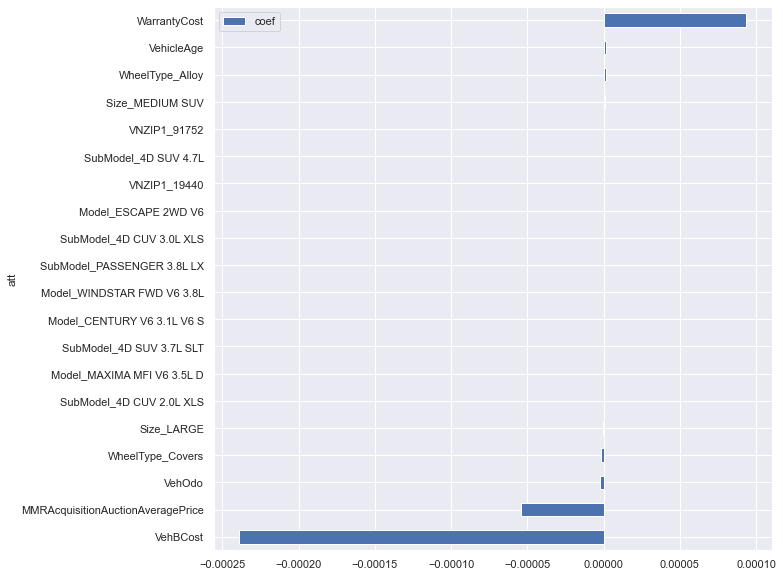

In [347]:
coefs = pd.DataFrame({'att':X_train_reduced.columns, 'coef':model_lr.coef_[0]}).sort_values(by='coef',ascending=True)
coefs.plot.barh(x='att',y='coef',figsize=(10, 10))

## AdaBoost

In [349]:
from sklearn.ensemble import AdaBoostClassifier

model_boost = AdaBoostClassifier(base_estimator=forest, n_estimators=10, learning_rate=0.2, random_state = RAND_STATE)
cross_validate(model_boost, X_ros, y_ros, cv = 10, scoring='accuracy')['test_score'].mean()

0.9746197299685673

### AdaBoost primenjen na test podacima

In [350]:
model_boost.fit(X_ros, y_ros)
y_hat = model_boost.predict(X_test_reduced)
rf_ada_boost_auc = roc_auc_score(y_test, model_boost.predict_proba(X_test_reduced)[:, 1])
print(f'Accuracy {accuracy_score(y_test, y_hat)}')
print('AUC: ', rf_ada_boost_auc)
print(confusion_matrix(y_test, y_hat))

Accuracy 0.8362831858407079
AUC:  0.6223840632466688
[[1118   65]
 [ 157   16]]


## Poredjenje dobijenih rezultata

In [351]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_eval_metrics(y, y_hat, pos_label):
    return {'Accuracy': accuracy_score(y, y_hat), 'Precision': precision_score(y, y_hat, pos_label = pos_label), 'Recall': recall_score(y, y_hat, pos_label = pos_label), 'F1': f1_score(y, y_hat, pos_label=pos_label)}

### Metrike za IsBadBuy == 'Yes'

In [352]:
rf_df = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, forest.predict(X_test_reduced), 'Yes').items()}, index=['Random forest'])
bagging_df = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, model_bagging.predict(X_test_reduced), 'Yes').items()}, index=['Random forest with Bagging'])
ada_boost_df = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, model_boost.predict(X_test_reduced), 'Yes').items()}, index=['Random forest with AdaBoost'])
pd.concat([rf_df, bagging_df, ada_boost_df])

,Accuracy,Precision,Recall,F1
Random forest,0.837758,0.186667,0.080925,0.112903
Random forest with Bagging,0.799410,0.180645,0.161850,0.170732
Random forest with AdaBoost,0.836283,0.197531,0.092486,0.125984


### Metrike za IsBadBuy == 'No'

In [353]:

rf_df = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, forest.predict(X_test_reduced), 'No').items()}, index=['Random forest'])
bagging_df = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, model_bagging.predict(X_test_reduced), 'No').items()}, index=['Random forest with Bagging'])
ada_boost_df = pd.DataFrame({metric: [score] for metric, score in compute_eval_metrics(y_test, model_boost.predict(X_test_reduced), 'No').items()}, index=['Random forest with AdaBoost'])
pd.concat([rf_df, bagging_df, ada_boost_df])

,Accuracy,Precision,Recall,F1
Random forest,0.837758,0.875878,0.948436,0.910714
Random forest with Bagging,0.799410,0.879267,0.892646,0.885906
Random forest with AdaBoost,0.836283,0.876863,0.945055,0.909683


## ROC AUC

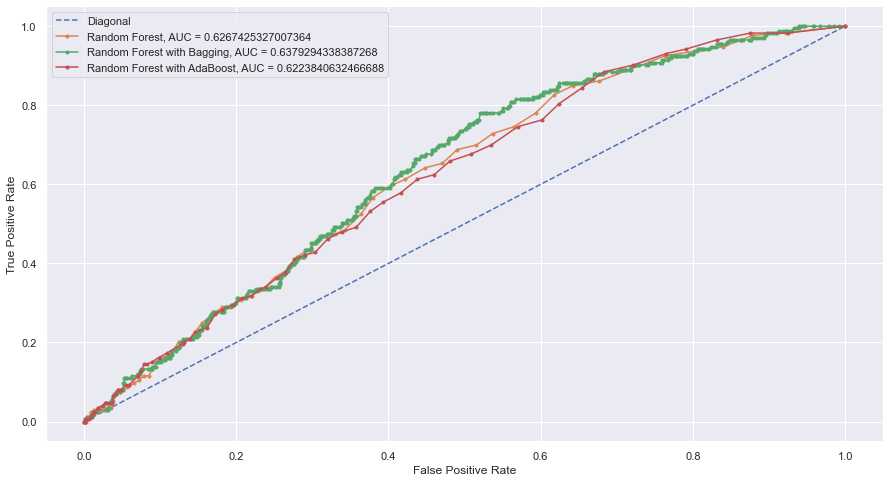

In [354]:
from sklearn.metrics import roc_curve

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test.map({'No': 0, 'Yes': 1}), ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test.map({'No': 0, 'Yes': 1}), forest.predict_proba(X_test_reduced)[:, 1])
rf_bagging_fpr, rf_bagging_tpr, _ = roc_curve(y_test.map({'No': 0, 'Yes': 1}), model_bagging.predict_proba(X_test_reduced)[:, 1])
rf_ada_boost_fpr, rf_ada_boost_tpr, _ = roc_curve(y_test.map({'No': 0, 'Yes': 1}), model_boost.predict_proba(X_test_reduced)[:, 1])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Diagonal')
plt.plot(rf_fpr, rf_tpr, marker='.', label=f'Random Forest, AUC = {rf_auc}')
plt.plot(rf_bagging_fpr, rf_bagging_tpr, marker='.', label=f'Random Forest with Bagging, AUC = {rf_bagging_auc}')
plt.plot(rf_ada_boost_fpr, rf_ada_boost_tpr, marker='.', label=f'Random Forest with AdaBoost, AUC = {rf_ada_boost_auc}')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Threshold

In [355]:
verovatnoce = forest.predict_proba(X_test_reduced)
granica = 0.7
predvidjanja = np.array(['No' if x > granica else 'Yes' for x in verovatnoce[:, 0]])
print(accuracy_score(y_test, predvidjanja))
print(roc_auc_score(y_test, verovatnoce[:, 1]))

0.7205014749262537
0.6267425327007364


In [356]:
confusion_matrix(y_test, predvidjanja)

array([[922, 261],
       [118,  55]])